In [1]:
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional
from torch.utils.data import random_split
from torch.utils.data import DataLoader

import torchvision as tv
import torchvision.models as models
import torchvision.transforms as transforms
from torchvision.models import ResNet18_Weights
from torchvision.models import ResNet34_Weights
from torchvision.models import ResNet50_Weights
import torch.nn.functional as F
from torch.optim import lr_scheduler

import matplotlib.pyplot as plt

In [18]:
train_data_tensor = torch.load('./data_tensor.pth')
train_labels_tensor = torch.load('./labels_tensor.pth')
val_data_tensor = torch.load('./val_data_tensor.pth')
val_labels_tensor = torch.load('./val_labels_tensor.pth')

In [19]:
train_dataset, val_dataset = [], []
for i in range(len(train_labels_tensor)):
    train_dataset.append((train_data_tensor[i], train_labels_tensor[i]))

for i in range(len(val_labels_tensor)):
    val_dataset.append((val_data_tensor[i], val_labels_tensor[i]))

In [20]:
torch.manual_seed(42)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=True)

In [6]:
resnet18 = models.resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)

In [43]:
out_features1 = 128
p = 0.5

class RESNET18(nn.Module):
    def __init__(self):
        super(RESNET18, self).__init__()

        self.resnet = nn.Sequential(*list(resnet18.children())[:-1])
        
        self.fc1 = nn.Linear(resnet18.fc.in_features, out_features1)
        self.fc2 = nn.Linear(out_features1, 30)

        self.batchnorm = nn.BatchNorm1d(out_features1)

        self.dropout = nn.Dropout(p)

    def forward(self, x):
        x = self.resnet(x)
        x = x.view(x.size(0), -1)
        
        x = F.relu(self.batchnorm(self.fc1(x)))
        x = self.dropout(x)
        x = self.fc2(x)

        return x

In [87]:
# get the accuracy of the model prediction and the actual value
def get_accuracy(model, train=False):
    correct = 0
    total = 0
    if train:
        for imgs, labels in train_loader:
            if torch.backends.mps.is_built():
                imgs = imgs.to("mps")
                labels = labels.to("mps")

            output = model(imgs)

            # select index with maximum prediction
            pred = output.max(1, keepdim=True)[1]
            correct += pred.eq(labels.view_as(pred)).sum().item()
            total += imgs.shape[0]

    else:
        with torch.no_grad():
            correct = 0
            total = 0
            for imgs, labels in val_loader:
                model.eval()
                if torch.backends.mps.is_built():
                    imgs = imgs.to("mps")
                    labels = labels.to("mps")
                # get the output using alex net
                output = model(imgs)

                val_loss.append(criterion(output, labels))

                # select index with maximum prediction
                pred = output.max(1, keepdim=True)[1]
                correct += pred.eq(labels.view_as(pred)).sum().item()
                total += imgs.shape[0]
    
    return correct / total

In [109]:
# train the model using resnet
def train(model, data, batch_size, num_epochs, learning_rate, momentum, verbose=False):
    optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)
    scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

    # iters, losses, train_acc, val_acc = [], [], [], []


    n = 0
    for epoch in range(num_epochs):
        mini_b = 0
        mini_batch_correct = 0
        mini_batch_total = 0
        print("epoch: {}".format(epoch))
        epochs.append(epoch)

        for imgs, labels in iter(data):
            if torch.backends.mps.is_built():
                imgs = imgs.to("mps")
                labels = labels.to("mps")
            # calculate loss
            out = model(imgs)
            loss = criterion(out, labels)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            # find the loss and accuracy
            pred = out.max(1, keepdim=True)[1]
            mini_batch_correct = pred.eq(labels.view_as(pred)).sum().item()
            mini_batch_total = imgs.shape[0]
            train_acc.append(mini_batch_correct / mini_batch_total)
            train_loss.append(float(loss) / batch_size)
            iters.append(n)
            n += 1
            mini_b += 1
            
            if verbose and n % 10 == 0:
                print("Iteration: {} Training Accuracy: {} Loss: {}".format(n, train_acc[-1], losses[-1]))
        val_acc.append(get_accuracy(model, train=False))
        scheduler.step()
        # print the accuracy
        print("Training Accuracy = {}".format(train_acc[-1]))
        print("Validation Accuracy = {}".format(val_acc[-1]))

    # print the final accuracies
    print("Final Training Accuracy: {}".format(get_accuracy(model, train=True)))
    print("Validation Accuracy = {}".format(get_accuracy(model, train=False)))

In [110]:
    def draw_curve():
        # plot the loss curve
        plt.title("Loss Curve")
        plt.plot(iters, losses, label="Loss")
        plt.xlabel("Iterations")
        plt.ylabel("Loss")
        plt.show()

        # # plot the training and validation curve
        # plt.title("Training Curve")
        # plt.plot(epochs, train_acc, label="Training")
        # plt.plot(epochs, val_acc, label="Validation")
        # plt.xlabel("Iterations")
        # plt.ylabel("Accuracy")
        # plt.legend(loc='best')
        # plt.show()

In [77]:
torch.save(model, 'dropout_full_resnet18_2.pth')

In [78]:
# use resnet 
model = RESNET18()

iters, epochs, train_acc, val_acc, losses = [], [], [], [], []

# hyperparameters
num_epochs = 2
learning_rate = 0.0001
momentum = 0.9
batch_size = 64

if torch.backends.mps.is_built():
    model.to("mps")

train(model=model, data=train_loader, batch_size=batch_size, num_epochs=num_epochs, learning_rate=learning_rate, momentum=momentum, verbose=True)

model.cpu()

epoch: 0
Iteration: 10 Training Accuracy: 0.015625 Loss: 0.05491979420185089
Iteration: 20 Training Accuracy: 0.03125 Loss: 0.05323922261595726
Iteration: 30 Training Accuracy: 0.0625 Loss: 0.053187981247901917
Iteration: 40 Training Accuracy: 0.046875 Loss: 0.05052763223648071
Iteration: 50 Training Accuracy: 0.125 Loss: 0.0493050292134285
Iteration: 60 Training Accuracy: 0.140625 Loss: 0.04673295468091965
Iteration: 70 Training Accuracy: 0.203125 Loss: 0.04591101408004761
Iteration: 80 Training Accuracy: 0.140625 Loss: 0.045571811497211456
Iteration: 90 Training Accuracy: 0.28125 Loss: 0.0423508882522583
Iteration: 100 Training Accuracy: 0.359375 Loss: 0.041011929512023926
Iteration: 110 Training Accuracy: 0.359375 Loss: 0.040625497698783875
Iteration: 120 Training Accuracy: 0.453125 Loss: 0.03975345939397812
Iteration: 130 Training Accuracy: 0.546875 Loss: 0.03830882906913757
Iteration: 140 Training Accuracy: 0.46875 Loss: 0.03824979066848755
Iteration: 150 Training Accuracy: 0.625 

RESNET18(
  (resnet): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)

In [111]:
# use resnet 
model = RESNET18()

iters, epochs, train_acc, val_acc, train_loss, val_loss = [], [], [], [], [], []
criterion = nn.CrossEntropyLoss()

# hyperparameters
num_epochs = 2
learning_rate = 0.0001
momentum = 0.9
batch_size = 64

if torch.backends.mps.is_built():
    model.to("mps")

train(model=model, data=train_loader, batch_size=batch_size, num_epochs=num_epochs, learning_rate=learning_rate, momentum=momentum, verbose=True)

model.cpu()

epoch: 0
Iteration: 10 Training Accuracy: 0.015625 Loss: 0.000992895569652319
Iteration: 20 Training Accuracy: 0.046875 Loss: 0.000992895569652319
Iteration: 30 Training Accuracy: 0.078125 Loss: 0.000992895569652319
Iteration: 40 Training Accuracy: 0.140625 Loss: 0.000992895569652319
Iteration: 50 Training Accuracy: 0.15625 Loss: 0.000992895569652319
Iteration: 60 Training Accuracy: 0.203125 Loss: 0.000992895569652319
Iteration: 70 Training Accuracy: 0.28125 Loss: 0.000992895569652319
Iteration: 80 Training Accuracy: 0.25 Loss: 0.000992895569652319
Iteration: 90 Training Accuracy: 0.328125 Loss: 0.000992895569652319
Iteration: 100 Training Accuracy: 0.4375 Loss: 0.000992895569652319
Iteration: 110 Training Accuracy: 0.390625 Loss: 0.000992895569652319
Iteration: 120 Training Accuracy: 0.390625 Loss: 0.000992895569652319
Iteration: 130 Training Accuracy: 0.515625 Loss: 0.000992895569652319
Iteration: 140 Training Accuracy: 0.59375 Loss: 0.000992895569652319
Iteration: 150 Training Accur

RESNET18(
  (resnet): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)

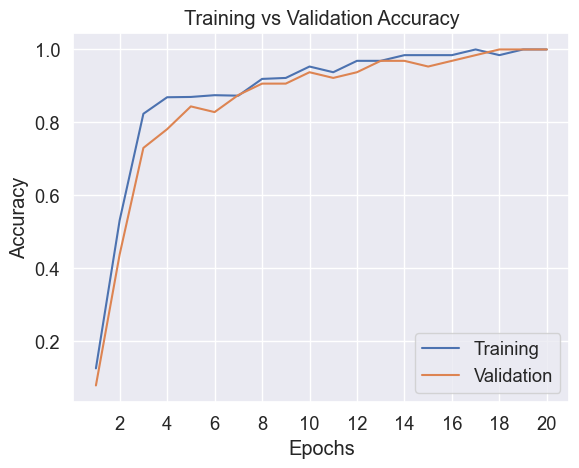

In [173]:
plt.title("Training vs Validation Accuracy")
plt.plot(epochs, train_acc, label="Training")
plt.plot(epochs, val_acc, label="Validation")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(loc='best')
plt.gca().xaxis.set_major_locator(plt.MultipleLocator(2))
plt.show()

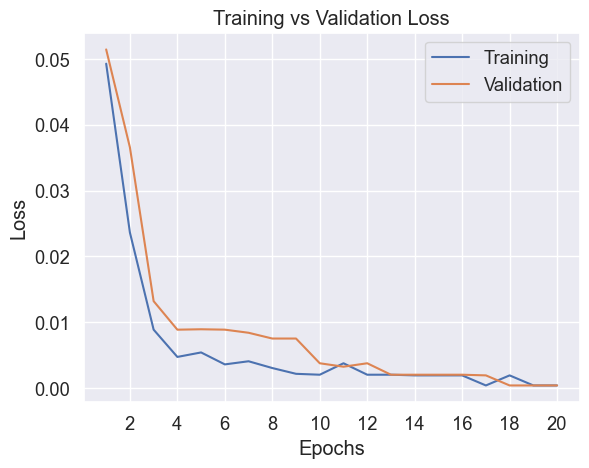

In [177]:
plt.title("Training vs Validation Loss")
plt.plot(epochs, train_loss, label="Training")
plt.plot(epochs, val_loss, label="Validation")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(loc='best')
plt.gca().xaxis.set_major_locator(plt.MultipleLocator(2))
plt.show()

In [114]:
model.cpu()

RESNET18(
  (resnet): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)